<a href="https://colab.research.google.com/github/micheleguidaa/robust-organ-scheduler/blob/main/robust_organ_scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pianificazione Robusta dell'Orario di Prelievo in Interventi di Trapianto

**Studente:** Michele Guida  
**Corso:** Decision Support Systems  
**Repository:** [github.com/micheleguidaa/robust-organ-scheduler](https://github.com/micheleguidaa/robust-organ-scheduler)

In [440]:
# Import delle librerie necessarie
import numpy as np
import bisect
import random
from datetime import datetime, date, timedelta
from typing import Sequence, Mapping, Tuple, Optional, List, Dict
import seaborn as sns

# Impostazione del seed per la riproducibilità
random.seed(64)
np.random.seed(64)

## 1. Definizione del Problema

Il progetto affronta la scelta dell'orario di inizio ($t_{start}$) di un intervento di prelievo multi-organo da un singolo donatore.
L'obiettivo è minimizzare i ritardi di partenza dei mezzi di trasporto assegnati ai diversi organi, tenendo conto
della diversa importanza clinica e dell'incertezza sulla durata dell'intervento.

### Modello Matematico

Sia $\mathbf{T}$ l'insieme discreto degli orari di inizio possibili e $\mathbf{D} = \{d_{min}, d_{med}, d_{max}\}$ l'insieme delle possibili durate dell'intervento.

Definiamo il **tempo di attesa** $\delta_i$ per l'organo $i$ come il tempo che intercorre tra la disponibilità dell'organo (fine intervento) e la prima partenza utile del mezzo di trasporto $S_i^j$:

$$
\delta_{i}(t_{start},d) = \min_{j: S_{i}^{j} \ge t_{start}+d} (S_{i}^{j} - (t_{start}+d))
$$

La **funzione di costo** (ritardo totale pesato) per uno scenario è data da:

$$
F(t_{start},d) = \sum_{i \in \mathbf{I}} w_{i} \cdot \delta_{i}(t_{start},d)
$$

### Obiettivo: Ottimizzazione Robusta (Minimax)
Poiché la durata $d$ è incerta, adottiamo un approccio robusto che minimizza il costo nel *caso peggiore* (worst-case scenario):

$$
t_{start}^* = \arg \min_{t_{start} \in \mathbf{T}} \left( \max_{d \in \mathbf{D}} F(t_{start}, d) \right)
$$

## 2. Soluzione e Implementazione dell'Algoritmo

Proponiamo due varianti dell'algoritmo in base alle assunzioni sulla struttura dei dati di input (orari di partenza degli organi).

### Soluzione Unificata

Abbiamo implementato un'unica funzione `robust_organ_scheduler` che permette di scegliere l'algoritmo di ricerca più adatto in base alle caratteristiche dei dati di input, tramite il parametro `algorithm_type`.

#### Modalità: `unsorted` (Partenze NON Ordinate)
*   **Descrizione:** Non fa alcuna assunzione sull'ordinamento degli orari di partenza. Scansiona l'intera lista per trovare la prima partenza utile.
*   **Approccio:** Scansione Lineare (Linear Scan).
*   **Complessità:** $O\left( |\mathbf{T}| \cdot |\mathbf{D}| \cdot \sum_{i=1}^{N} |\mathbf{S}_i| \right)$.
*   **Utilizzo:** Adatta quando i dati provengono da fonti non strutturate.

#### Modalità: `sorted` (Partenze ORDINATE)
*   **Descrizione:** Assume che le liste degli orari di partenza $\mathbf{S}_i$ siano **già ordinate**. Utilizza la ricerca binaria per trovare efficientemente la partenza successiva.
*   **Approccio:** Ricerca Binaria (Binary Search).
*   **Complessità:** $O\left( |\mathbf{T}| \cdot |\mathbf{D}| \cdot \sum_{i=1}^{N} \log |\mathbf{S}_i| \right)$.
*   **Vantaggio:** Riduce drasticamente il tempo di calcolo per liste di partenze numerose.

In [441]:
# ---------------------------------------------------------
# 2. SOLUZIONE UNIFICATA (Sorted / Unsorted)
# ---------------------------------------------------------
def robust_organ_scheduler(
    orari_possibili_inizio_intervento: Sequence[datetime],
    durate_possibili_intervento: Sequence[timedelta],
    organi: Sequence[str],
    orari_partenza: Mapping[str, Sequence[datetime]],
    pesi: Mapping[str, float],
    algorithm_type: str = 'unsorted' # 'sorted' or 'unsorted'
) -> Tuple[float, Optional[datetime], timedelta, Dict[str, float]]:
    """
    Risolve il problema di pianificazione dell'orario di inizio intervento utilizzando un approccio di Ottimizzazione Robusta (Minimax).
    
    L'algoritmo cerca l'orario di inizio (t_start) che minimizza il massimo ritardo pesato (funzione di costo) 
    considerando tutti i possibili scenari di durata dell'intervento.
    
    Args:
        orari_possibili_inizio_intervento (Sequence[datetime]): Lista degli orari candidati per l'inizio dell'intervento.
        durate_possibili_intervento (Sequence[timedelta]): Insieme delle possibili durate dell'intervento (incertezza).
        organi (Sequence[str]): Lista degli organi da prelevare.
        orari_partenza (Mapping[str, Sequence[datetime]]): Dizionario che associa a ogni organo la lista dei suoi orari di partenza disponibili.
        pesi (Mapping[str, float]): Dizionario dei pesi (priorità clinica) per ciascun organo.
        algorithm_type (str, optional): Strategia di ricerca. 
            - 'sorted': Assume liste ordinate e usa Ricerca Binaria (O(log N)).
            - 'unsorted': Usa Scansione Lineare (O(N)). Default è 'unsorted'.

    Returns:
        Tuple[float, Optional[datetime], timedelta, Dict[str, float]]: Una tupla contenente:
            1. funzione_obiettivo (float): Il valore minimo del ritardo massimo pesato trovato (Minimax value).
            2. migliore_orario (Optional[datetime]): L'orario di inizio intervento che realizza il minimo. None se non trovato.
            3. tempo_esecuzione (timedelta): Tempo impiegato per il calcolo.
            4. migliori_attese (Dict[str, float]): Dizionario dei tempi di attesa (in minuti) per ciascun organo nella soluzione ottima.
    """
    inizio_esecuzione = datetime.now()
    funzione_obiettivo = np.inf
    migliore_orario = None
    migliori_attese = {}

    for orario_inizio in orari_possibili_inizio_intervento:
        somma_pesata_attese_max = -np.inf
        attese_worst_case_corrente = {}

        for durata in durate_possibili_intervento:
            somma_pesata_attese = 0.0
            orario_fine = orario_inizio + durata
            attese_correnti = {}

            for organo in organi:
                lista_partenze = orari_partenza[organo]
                attesa_minuti = np.inf
                
                if algorithm_type == 'sorted':
                    # RICERCA BINARIA (O(log N))
                    # bisect_left restituisce l'indice del primo elemento >= orario_fine
                    idx = bisect.bisect_left(lista_partenze, orario_fine)
                    
                    if idx < len(lista_partenze):
                        prima_partenza = lista_partenze[idx]
                        attesa_minuti = (prima_partenza - orario_fine).total_seconds() / 60
                        somma_pesata_attese += pesi[organo] * attesa_minuti
                    else:
                        somma_pesata_attese = np.inf
                        # Non facciamo break subito per poter salvare l'attesa infinita nel dizionario se necessario,
                        # ma per efficienza se la somma è inf possiamo fermarci dopo aver registrato.
                
                elif algorithm_type == 'unsorted':
                    # SCANSIONE LINEARE (O(N))
                    partenze_valide = [p for p in lista_partenze if p >= orario_fine]
                    
                    if partenze_valide:
                        prima_partenza = min(partenze_valide)
                        attesa_minuti = (prima_partenza - orario_fine).total_seconds() / 60
                        somma_pesata_attese += pesi[organo] * attesa_minuti
                    else:
                        somma_pesata_attese = np.inf
                else:
                    raise ValueError(f"Algorithm type '{algorithm_type}' not recognized. Use 'sorted' or 'unsorted'.")
                
                attese_correnti[organo] = attesa_minuti
                
                if somma_pesata_attese == np.inf:
                    break

            if somma_pesata_attese > somma_pesata_attese_max:
                somma_pesata_attese_max = somma_pesata_attese
                attese_worst_case_corrente = attese_correnti

        if somma_pesata_attese_max < funzione_obiettivo:
            funzione_obiettivo = somma_pesata_attese_max
            migliore_orario = orario_inizio
            migliori_attese = attese_worst_case_corrente

    tempo_esecuzione = datetime.now() - inizio_esecuzione
    return funzione_obiettivo, migliore_orario, tempo_esecuzione, migliori_attese

## 3. Verifica Funzionale (Test Case Semplice)

Prima di procedere con la sperimentazione su dati sintetici, eseguiamo un **Test Case Deterministico** per validare la correttezza dell'algoritmo.

In questo scenario semplificato:
*   Consideriamo solo **2 orari di inizio** candidati (08:00 e 09:00).
*   Assumiamo una **durata fissa** di 2 ore (nessuna incertezza sulla durata in questo test).
*   Gli orari di partenza dei mezzi sono stati costruiti ad-hoc per rendere l'orario delle **08:00** chiaramente preferibile rispetto alle 09:00.

L'obiettivo è confermare che la funzione `robust_organ_scheduler` identifichi correttamente l'ottimo globale (08:00) e calcoli il valore della funzione obiettivo atteso (5700).

In [442]:
print("=== TEST CASE SEMPLICE (Verifica Manuale) ===")

# 1. Setup Scenario Semplificato
# Data base: Oggi alle 00:00
base_date = datetime.combine(date.today(), datetime.min.time())

# Due possibili orari di inizio: 08:00 e 09:00
test_orari_inizio = [
    base_date + timedelta(hours=8),
    base_date + timedelta(hours=9)
]

# Una sola durata possibile: 2 ore (per semplificare il calcolo)
test_durate = [timedelta(hours=2)]


# Organi richiesti
test_organi = ['Cuore', 'Polmoni', 'Fegato', 'Rene_sx', 'Rene_dx']

# Pesi specificati
test_pesi = {
    'Cuore': 100.0,
    'Polmoni': 90.0,
    'Fegato': 20.0,
    'Rene_sx': 20.0,
    'Rene_dx': 20.0
}

# Orari di partenza del trasporto
# Scenario costruito per favorire l'inizio alle 08:00.
# Se inizio 08:00 -> Fine 10:00.
# Se inizio 09:00 -> Fine 11:00.

test_partenze = {
    
    # Cuore (Peso 100): 
    # - 10:30 (attesa 30 min se fine 10:00)
    # - 12:00 (attesa 60 min se fine 11:00) -> Penalizza molto le 09:00
    
    'Cuore': [
        base_date + timedelta(hours=10, minutes=30), 
        base_date + timedelta(hours=12, minutes=0)
    ],
    
    # Polmoni (Peso 90):
    # - 10:30 (attesa 30 min se fine 10:00)
    # - 11:30 (attesa 30 min se fine 11:00) -> Neutro
    
    'Polmoni': [
        base_date + timedelta(hours=10, minutes=30), 
        base_date + timedelta(hours=11, minutes=30)
    ],
    
    # Altri organi (Peso 20): partenze comode per entrambi gli orari
    'Fegato': [base_date + timedelta(hours=10, minutes=0), base_date + timedelta(hours=11, minutes=0)], # Attesa 0
    'Rene_sx': [base_date + timedelta(hours=10, minutes=0), base_date + timedelta(hours=11, minutes=0)], # Attesa 0
    'Rene_dx': [base_date + timedelta(hours=10, minutes=0), base_date + timedelta(hours=11, minutes=0)]  # Attesa 0
}

print(f"Orari Inizio Candidati: {[t.strftime('%H:%M') for t in test_orari_inizio]}")
print(f"Durata Intervento: {test_durate[0]}")
print("Pesi:", test_pesi)

# 2. Esecuzione
val_obj, best_time, _, best_waits = robust_organ_scheduler(
    test_orari_inizio, 
    test_durate, 
    test_organi, 
    test_partenze, 
    test_pesi,
    algorithm_type='sorted'
)

# 3. Verifica
# Calcolo Costi Previsti:

# Caso A (Inizio 08:00 -> Fine 10:00):
# - Cuore: parte 10:30 -> attesa 30 min * 100 = 3000
# - Polmoni: parte 10:30 -> attesa 30 min * 90 = 2700
# - Altri: partono 10:00 -> attesa 0
# Totale A = 5700

# Caso B (Inizio 09:00 -> Fine 11:00):
# - Cuore: parte 12:00 -> attesa 60 min * 100 = 6000
# - Polmoni: parte 11:30 -> attesa 30 min * 90 = 2700
# - Altri: partono 11:00 -> attesa 0
# Totale B = 8700

# L'algoritmo deve scegliere 08:00.

print(f"\n--- Risultato Atteso ---")
print("Miglior orario: 08:00")
print("Costo atteso (approx): 5700")

print(f"\n--- Risultato Ottenuto ---")
print(f"Miglior orario: {best_time.strftime('%H:%M') if best_time else 'None'}")
print(f"Valore Obiettivo: {val_obj}")
print("Attese calcolate:", best_waits)

assert best_time == test_orari_inizio[0], "Errore: L'orario scelto non è quello atteso!"
assert val_obj == 5700.0, f"Errore: Il costo calcolato ({val_obj}) non è 5700!"
print("\n>>> TEST SUPERATO CON SUCCESSO! <<<")

=== TEST CASE SEMPLICE (Verifica Manuale) ===
Orari Inizio Candidati: ['08:00', '09:00']
Durata Intervento: 2:00:00
Pesi: {'Cuore': 100.0, 'Polmoni': 90.0, 'Fegato': 20.0, 'Rene_sx': 20.0, 'Rene_dx': 20.0}

--- Risultato Atteso ---
Miglior orario: 08:00
Costo atteso (approx): 5700

--- Risultato Ottenuto ---
Miglior orario: 08:00
Valore Obiettivo: 5700.0
Attese calcolate: {'Cuore': 30.0, 'Polmoni': 30.0, 'Fegato': 0.0, 'Rene_sx': 0.0, 'Rene_dx': 0.0}

>>> TEST SUPERATO CON SUCCESSO! <<<


# Test e Valutazione delle Prestazioni

## Obiettivo
La fase di test ha lo scopo di valutare le prestazioni delle due varianti dell’algoritmo utilizzando dataset sintetici con caratteristiche controllate.  

---

## Pesi degli Organi

Nell’esperimento sono stati assegnati pesi differenziati agli organi per riflettere la loro diversa priorità clinica.

$$
w_{\text{Cuore}} = 100,\quad
w_{\text{Polmoni}} = 90,\quad
w_{\text{Rene\,Sx}} = 20,\quad
w_{\text{Rene\,Dx}} = 20,\quad
w_{\text{Fegato}} = 20.
$$

Questi pesi vengono utilizzati nella funzione obiettivo per modulare il contributo del tempo di attesa dei singoli organi.

---

## Generazione dei Dati Sintetici

### 1. Orari di inizio intervento

Gli orari di inizio vengono generati come una sequenza crescente avente queste regole:

- `t_0 = 0`
- `t_1 ∈ [0.5 h, 1 h, 1.5 h, 2 h]`
- `t_2 ∈ (t_1, t_1 + 0.5 h, ..., 3 h]`
- `t_3 ∈ (t_2, t_2 + 0.5 h, ..., 5 h]`

Da notare come gli orari vengano generati con passi di 30 minuti (0.5 h).

Tale sequenza soddisfa:

$$
0 = t_0 < t_1 < t_2 < t_3 \le 5\text{ h}.
$$

L’insieme dei tempi ammissibili è:

$$
\mathbf{T} = \{t_0,\; t_1,\; t_2,\; t_3\}.
$$

---

### 2. Orari di partenza degli organi

Per ogni organo $ i $, gli orari di partenza sono generati come valori uniformi nell’intervallo discreto:

$$
S_i^j \in [0,\; 0.5,\; 1,\; \ldots,\; 23,\; 23.5\;] \;\text{h}
$$

Anche in questo caso, gli orari sono generati con passi di 30 minuti (0.5 h).

Ciascun organo casualmente riceve un numero di orari di partenza compreso tra 10 e 35.

---

### 3. Durata dell’intervento

La durata dell’intervento è considerata incerta e può assumere uno dei seguenti valori:

$$
d \in \{2,\; 4,\; 6\}\text{ h}.
$$

---

## Protocollo di Test

Per ogni configurazione sperimentale:

- l’esperimento viene ripetuto **50 volte** con diversi dataset generati casualmente;
- per ciascun run vengono registrati e salvati:
  - i parametri di input generati,
  - il tempo di esecuzione,
  - la soluzione ottimale,
  - il tempo di attesa di ciascun organo.

Dai risultati si ricavano:

- il **tempo medio e deviazione standard di esecuzione**,  
- il **valore medio e deviazione standard della soluzione pesata**,  
- il **tempo medio di attesa per organo**,
- il **tempo massimo di attesa per organo**.

---

## Analisi di Sensitività sulla Densità degli Orari di Partenza

Per valutare l’effetto della riduzione della densità degli orari di partenza:

1. si ordinano i valori $ S_i^j $ per ogni organo;
2. si rimuove un orario ogni due (pattern alternato);
3. si ripete l’intero processo di test sulla nuova configurazione.

L’analisi consente di esaminare l’impatto della variazione della granularità dei dati su:

- tempo di esecuzione,
- qualità della soluzione,
- robustezza dell’algoritmo (in presenza dei pesi $ w_i $).

---

In [443]:
# ---------------------------------------------------------
# CONFIGURAZIONE SPERIMENTALE
# ---------------------------------------------------------
ORGANI = ['Cuore', 'Polmoni', 'Rene_sx', 'Rene_dx', 'Fegato']

# Pesi aggiornati come da descrizione nel testo
PESO_ORGANI = {
    'Cuore': 100.0,
    'Polmoni': 90.0,
    'Rene_sx': 20.0,     
    'Rene_dx': 20.0,
    'Fegato': 20.0
}

DURATA_POSSIBILI_INTERVENTO = [
    timedelta(hours=2),
    timedelta(hours=4),
    timedelta(hours=6),
]

RUN = 50

# ---------------------------------------------------------
# 1. GENERAZIONE ORARI POSSIBILI DI INIZIO INTERVENTO
# ---------------------------------------------------------
def genera_orari_possibili_inizio_intervento(
    inizio_giorno: datetime = datetime.combine(date.today(), datetime.min.time())
) -> Sequence[datetime]:
    """
    Genera 4 istanti temporali t0, t1, t2, t3 per l'inizio dell'intervento.
    t0 = 0
    t1 in [0.5, 1, 1.5, 2] ore
    t2 in (t1, 3] ore
    t3 in (t2, 5] ore
    """
    
    passo = 30 # minuti
    
    # t_0 = 0
    t0_min = 0

    # t_1: scelta tra 30, 60, 90, 120 minuti
    possibili_t1 = [30, 60, 90, 120]
    t1_min = random.choice(possibili_t1)

    # t_2: strettamente maggiore di t1, fino a 180 min (3h)
    # range(start, stop, step) -> start = t1 + 30
    possibili_t2 = list(range(t1_min + passo, 180 + 1, passo))
    t2_min = random.choice(possibili_t2)

    # t_3: strettamente maggiore di t2, fino a 300 min (5h)
    possibili_t3 = list(range(t2_min + passo, 300 + 1, passo))
    t3_min = random.choice(possibili_t3)

    # Creazione lista datetime
    orari = [
        inizio_giorno + timedelta(minutes=t0_min),
        inizio_giorno + timedelta(minutes=t1_min),
        inizio_giorno + timedelta(minutes=t2_min),
        inizio_giorno + timedelta(minutes=t3_min)
    ]
    
    return orari

# ---------------------------------------------------------
# 2. GENERAZIONE ORARI DI PARTENZA DEGLI ORGANI
# ---------------------------------------------------------
def genera_orari_partenza_organi(
    organi: List[str],
    inizio_giorno: datetime = datetime.combine(date.today(), datetime.min.time())
) -> Dict[str, List[datetime]]:
    """
    Genera gli orari di partenza per una lista di organi.
    Dominio: [0, 0.5, ..., 23.5 h]
    Numero orari per organo: Random tra 10 e 35.
    """
    
    # Definizione del dominio temporale [0, 23.5h] a passi di 30 min
    # 23.5 ore * 60 min = 1410 min. 
    # Usiamo +1 nel range per includere l'estremo superiore (1410 min = 23:30).
    pool_minuti = list(range(0, (23 * 60) + 31, 30))
    
    risultato = {}

    for organo in organi:
        # Scelta numero di orari (tra 10 e 35)
        n_scelte = random.randint(10, 35)
        
        # Campionamento casuale senza ripetizioni
        scelte_minuti = random.sample(pool_minuti, n_scelte)
        
        # Ordinamento cronologico
        scelte_minuti.sort()
        
        # Conversione in datetime
        lista_orari = []
        for m in scelte_minuti:
            orario = inizio_giorno + timedelta(minutes=m)
            lista_orari.append(orario)
            
        risultato[organo] = lista_orari

    return risultato

In [444]:
# ---------------------------------------------------------
#  VERIFICA GENERAZIONE DATI (Sanity Check)
# ---------------------------------------------------------
print("=== TEST 1: Orari Inizio Intervento ===",end='\n')
print("\nT = [", end=' ')
orari_intervento = genera_orari_possibili_inizio_intervento()

for i, orario in enumerate(orari_intervento):
    print(f"t_{i}: {orario.strftime('%H:%M')}", end=' ')
print("]")

print("\n=== TEST 2: Orari Partenza Organi ===")
orari_organi = genera_orari_partenza_organi(ORGANI)

for organo, orari in orari_organi.items():
    # Calcoliamo quante partenze ci sono
    num_partenze = len(orari)
    # Formattiamo per la stampa
    str_orari = [o.strftime("%H:%M") for o in orari]
    
    print(f"\n--- {organo} (Peso: {PESO_ORGANI.get(organo, 'N/A')}) ---")
    print(f"Totale partenze: {num_partenze}")
    print(f"Primi 3 orari: {str_orari[:3]}")
    print(f"Ultimi 3 orari: {str_orari[-3:]}")

=== TEST 1: Orari Inizio Intervento ===

T = [ t_0: 00:00 t_1: 02:00 t_2: 02:30 t_3: 05:00 ]

=== TEST 2: Orari Partenza Organi ===

--- Cuore (Peso: 100.0) ---
Totale partenze: 22
Primi 3 orari: ['00:00', '00:30', '01:30']
Ultimi 3 orari: ['21:30', '22:30', '23:30']

--- Polmoni (Peso: 90.0) ---
Totale partenze: 18
Primi 3 orari: ['00:30', '02:30', '04:00']
Ultimi 3 orari: ['16:00', '17:00', '17:30']

--- Rene_sx (Peso: 20.0) ---
Totale partenze: 15
Primi 3 orari: ['00:00', '00:30', '01:30']
Ultimi 3 orari: ['21:30', '22:30', '23:30']

--- Rene_dx (Peso: 20.0) ---
Totale partenze: 19
Primi 3 orari: ['02:30', '04:30', '05:00']
Ultimi 3 orari: ['21:30', '22:00', '23:00']

--- Fegato (Peso: 20.0) ---
Totale partenze: 19
Primi 3 orari: ['00:30', '01:00', '01:30']
Ultimi 3 orari: ['22:00', '22:30', '23:30']


In [445]:
# ---------------------------------------------------------
# ESEMPIO DI SINGOLA ESECUZIONE (Single Run)
# ---------------------------------------------------------
print("=== ESEMPIO DI SINGOLA ESECUZIONE ===")

# 1. Generazione Dati
orari_intervento = genera_orari_possibili_inizio_intervento()
orari_partenze = genera_orari_partenza_organi(ORGANI)

print(f"Orari intervento possibili: {[t.strftime('%H:%M') for t in orari_intervento]}")
print(f"Durate possibili intervento: {[str(d) for d in DURATA_POSSIBILI_INTERVENTO]}")

print("\nOrari di Partenza Generati (Lista Completa):")
for organo, lista in orari_partenze.items():
    lista_str = [t.strftime('%H:%M') for t in lista]
    print(f"- {organo} ({len(lista)} partenze): {lista_str}")

# 2. Esecuzione Algoritmo
obj_val, opt_time, exec_time, wait_times = robust_organ_scheduler(
    orari_intervento,
    DURATA_POSSIBILI_INTERVENTO,
    ORGANI,
    orari_partenze,
    PESO_ORGANI,
    algorithm_type='sorted'
)

# 3. Stampa Risultati
print(f"\nRisultati Ottimizzazione:")
print(f"Miglior orario inizio intervento: {opt_time.strftime('%H:%M') if opt_time else 'Nessuna soluzione'}")
print(f"Valore Funzione Obiettivo: {obj_val:.2f}")
print(f"Tempo di esecuzione: {exec_time.total_seconds() * 1000:.4f} ms")

print("\nDettaglio Attese per Organo nella soluzione ottima:")
if wait_times:
    for organo, attesa in wait_times.items():
        print(f"- {organo}: {attesa:.2f} min")
else:
    print("Nessuna attesa calcolata (soluzione non trovata).")

=== ESEMPIO DI SINGOLA ESECUZIONE ===
Orari intervento possibili: ['00:00', '01:30', '03:00', '04:00']
Durate possibili intervento: ['2:00:00', '4:00:00', '6:00:00']

Orari di Partenza Generati (Lista Completa):
- Cuore (34 partenze): ['00:00', '01:00', '02:00', '02:30', '03:00', '03:30', '04:00', '05:00', '06:00', '07:00', '07:30', '08:00', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30', '13:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '19:00', '19:30', '20:00', '21:30', '22:00', '22:30', '23:00']
- Polmoni (18 partenze): ['00:30', '01:00', '02:30', '03:00', '03:30', '06:30', '11:30', '13:30', '15:00', '15:30', '16:00', '17:00', '17:30', '20:30', '21:00', '21:30', '22:30', '23:30']
- Rene_sx (22 partenze): ['00:00', '02:00', '02:30', '03:30', '04:30', '05:00', '06:30', '07:00', '08:00', '09:00', '10:30', '11:00', '12:00', '15:30', '16:30', '17:00', '18:00', '18:30', '19:00', '21:30', '23:00', '23:30']
- Rene_dx (19 partenze): ['00:30', '04:00', '0

## 4. Implementazione del Framework di Test

Di seguito implementiamo le funzioni necessarie per automatizzare la fase sperimentale.

### Caratteristiche dell'Implementazione:
*   **`genera_scenari`**: Genera una lista di scenari (orari intervento e partenze organi) che verranno utilizzati identici per tutti i test, garantendo la comparabilità dei risultati.
*   **`battery_test`**: Esegue una serie di run sugli scenari forniti.
    *   Esegue sia l'algoritmo `sorted` che `unsorted` per misurare i tempi di calcolo.
    *   Salva i risultati dettagliati in formato JSON nella cartella `results/`.
    *   Calcola e stampa statistiche aggregate (tempi medi, costo medio, attese medie, attese massime).

In [446]:
import json
import os
import copy

# ---------------------------------------------------------
# FASE SPERIMENTALE
# ---------------------------------------------------------

def genera_scenari(num_run, organi):
    """
    Genera una lista di scenari (input) da utilizzare per i test.
    Questo permette di usare gli stessi dati di partenza per diversi test (es. standard vs ridotto).
    """
    scenari = []
    for i in range(num_run):
        scenario = {
            "orari_intervento": genera_orari_possibili_inizio_intervento(),
            "orari_partenze_organi": genera_orari_partenza_organi(organi)
        }
        scenari.append(scenario)
    return scenari

def battery_test(organi, peso_organi, durate_possibili_intervento, scenari, riduci_densita=False, json_filename=None):
    
    num_run = len(scenari)
    
    # Creazione directory results se non esiste
    results_dir = "results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    if json_filename is None:
        if riduci_densita:
            nome_file = "risultati_test_densita_ridotta.json"
        else:
            nome_file = "risultati_test_standard.json"
        json_filename = os.path.join(results_dir, nome_file)
    else:
        # Se viene passato un nome file, assicuriamoci che sia dentro results se non ha già un path
        if os.path.dirname(json_filename) == "":
            json_filename = os.path.join(results_dir, json_filename)

    tempi_esecuzione_sorted = []
    tempi_esecuzione_unsorted = []
    valori_obiettivo = []
    attese_per_organo = {o: [] for o in organi}
    
    # Lista per raccogliere i dati di tutti i run
    dati_runs = []

    print(f"\n\nAvvio test batteria ({num_run} run) - Modalità riduci_densita={riduci_densita}...")

    for i, scenario in enumerate(scenari):
        # Recupero dati dallo scenario (copia profonda per non intaccare l'originale per altri test)
        orari_intervento = scenario['orari_intervento']
        orari_partenze_organi = copy.deepcopy(scenario['orari_partenze_organi'])

        if riduci_densita:
            # Rimuove un orario ogni due (pattern alternato)
            for organo in organi:
                # Assumiamo che siano già ordinati dalla funzione di generazione
                lista = orari_partenze_organi[organo]
                # Slice [::2] prende elementi a indici 0, 2, 4...
                orari_partenze_organi[organo] = lista[::2]
        
        # Esecuzione algoritmo robusto - SORTED
        valore_funzione_obiettivo_sorted, orario_ottimo_sorted, tempo_esecuzione_sorted_dt, attese_ottimali_sorted = robust_organ_scheduler(
            orari_intervento, 
            durate_possibili_intervento, 
            organi, 
            orari_partenze_organi, 
            peso_organi,
            algorithm_type='sorted'
        )

        # Esecuzione algoritmo robusto - UNSORTED
        valore_funzione_obiettivo_unsorted, orario_ottimo_unsorted, tempo_esecuzione_unsorted_dt, attese_ottimali_unsorted = robust_organ_scheduler(
            orari_intervento, 
            durate_possibili_intervento, 
            organi, 
            orari_partenze_organi, 
            peso_organi,
            algorithm_type='unsorted'
        )
        
        # Registrazione metriche (usiamo i risultati sorted per le statistiche generali)
        ms_esecuzione_sorted = tempo_esecuzione_sorted_dt.total_seconds() * 1000
        ms_esecuzione_unsorted = tempo_esecuzione_unsorted_dt.total_seconds() * 1000
        
        tempi_esecuzione_sorted.append(ms_esecuzione_sorted)
        tempi_esecuzione_unsorted.append(ms_esecuzione_unsorted)
        
        valori_obiettivo.append(valore_funzione_obiettivo_sorted)

        # Registrazione attese per lo scenario peggiore corrispondente alla soluzione ottima
        if orario_ottimo_sorted is not None:
            for organo, attesa in attese_ottimali_sorted.items():
                attese_per_organo[organo].append(attesa)
        
        # Preparazione dati per JSON
        run_info = {
            "run_id": i,
            "input": {
                "orari_intervento": [t.strftime('%H:%M') for t in orari_intervento],
                "orari_partenze_organi": {k: [v.strftime('%H:%M') for v in vals] for k, vals in orari_partenze_organi.items()},
                "riduci_densita": riduci_densita
            },
            "output": {
                "valore_funzione_obiettivo": valore_funzione_obiettivo_sorted if valore_funzione_obiettivo_sorted != np.inf else "Infinity",
                "orario_ottimo": orario_ottimo_sorted.strftime('%H:%M') if orario_ottimo_sorted else None,
                "tempo_esecuzione_sorted_ms": ms_esecuzione_sorted,
                "tempo_esecuzione_unsorted_ms": ms_esecuzione_unsorted,
                "attese_ottimali": attese_ottimali_sorted
            }
        }
        dati_runs.append(run_info)

    # Salvataggio su file JSON
    try:
        with open(json_filename, "w") as f:
            json.dump(dati_runs, f, indent=4)
        print(f"Dati dei run salvati correttamente in '{json_filename}'")
    except Exception as e:
        print(f"Errore durante il salvataggio del file JSON: {e}")

    # Calcolo statistiche
    mean_exec_sorted = np.mean(tempi_esecuzione_sorted)
    std_exec_sorted = np.std(tempi_esecuzione_sorted)
    
    mean_exec_unsorted = np.mean(tempi_esecuzione_unsorted)
    std_exec_unsorted = np.std(tempi_esecuzione_unsorted)
    
    mean_obj = np.mean(valori_obiettivo)
    std_obj = np.std(valori_obiettivo)

    print("\n--- RISULTATI ---")
    print(f"Tempo medio esecuzione (Sorted): {mean_exec_sorted:.4f} ms (std: {std_exec_sorted:.4f})")
    print(f"Tempo medio esecuzione (Unsorted): {mean_exec_unsorted:.4f} ms (std: {std_exec_unsorted:.4f})")
    print(f"Valore medio funzione obiettivo: {mean_obj:.2f} (std: {std_obj:.2f})")
    
    print("\nStatistiche per Organo (Attesa Worst-Case):")
    print(f"{'Organo':<10} | {'Media (minuti)':<12} | {'Max (minuti)':<10}")
    print("-" * 36)
    for o in organi:
        if attese_per_organo[o]:
            # Filtriamo eventuali infiniti per le statistiche
            valid_attese = [x for x in attese_per_organo[o] if x != np.inf]
            if valid_attese:
                m = np.mean(valid_attese)
                mx = np.max(valid_attese)
                print(f"{o:<10} | {m:<12.2f} | {mx:<10.2f}")
            else:
                print(f"{o:<10} | {'Inf':<12} | {'Inf':<10}")
        else:
             print(f"{o:<10} | {'N/A':<12} | {'N/A':<10}")
    print("-" * 36)

### 4.1 Esecuzione Test Standard

In questa fase generiamo gli scenari condivisi ed eseguiamo il test sulla configurazione base (tutti gli orari di partenza disponibili).

In [447]:
# Generazione Scenari Condivisi
print("Generazione scenari condivisi...")
SCENARI_CONDIVISI = genera_scenari(RUN, ORGANI)

# Esecuzione Test Standard
battery_test(ORGANI, PESO_ORGANI, DURATA_POSSIBILI_INTERVENTO, SCENARI_CONDIVISI, riduci_densita=False)

Generazione scenari condivisi...


Avvio test batteria (50 run) - Modalità riduci_densita=False...
Dati dei run salvati correttamente in 'results/risultati_test_standard.json'

--- RISULTATI ---
Tempo medio esecuzione (Sorted): 0.0269 ms (std: 0.0036)
Tempo medio esecuzione (Unsorted): 0.0810 ms (std: 0.0096)
Valore medio funzione obiettivo: 11304.00 (std: 8267.70)

Statistiche per Organo (Attesa Worst-Case):
Organo     | Media (minuti) | Max (minuti)
------------------------------------
Cuore      | 43.80        | 180.00    
Polmoni    | 44.40        | 540.00    
Rene_sx    | 54.60        | 390.00    
Rene_dx    | 48.00        | 270.00    
Fegato     | 43.80        | 270.00    
------------------------------------


### 4.2 Analisi di Sensitività (Densità Ridotta)

Utilizzando **gli stessi scenari** generati al passo precedente, eseguiamo il test riducendo la densità degli orari di partenza (rimuovendo un orario ogni due).
Questo ci permette di valutare come la granularità dei trasporti influenzi la qualità della soluzione e i tempi di calcolo, a parità di condizioni iniziali.

In [448]:
# Esecuzione Test Analisi di Sensitività (Densità Ridotta) - Usa gli stessi scenari!
battery_test(ORGANI, PESO_ORGANI, DURATA_POSSIBILI_INTERVENTO, SCENARI_CONDIVISI, riduci_densita=True)



Avvio test batteria (50 run) - Modalità riduci_densita=True...
Dati dei run salvati correttamente in 'results/risultati_test_densita_ridotta.json'

--- RISULTATI ---
Tempo medio esecuzione (Sorted): 0.0264 ms (std: 0.0032)
Tempo medio esecuzione (Unsorted): 0.0554 ms (std: 0.0049)
Valore medio funzione obiettivo: 22152.00 (std: 11897.01)

Statistiche per Organo (Attesa Worst-Case):
Organo     | Media (minuti) | Max (minuti)
------------------------------------
Cuore      | 78.00        | 270.00    
Polmoni    | 108.00       | 630.00    
Rene_sx    | 86.40        | 630.00    
Rene_dx    | 63.00        | 510.00    
Fegato     | 82.20        | 270.00    
------------------------------------


## 5. Visualizzazione e Analisi dei Risultati
Per facilitare l'analisi dei risultati ottenuti dai test, grafichiamo i seguenti grafici:
1. Boxplot dei tempi di esecuzione delle due varianti dell'algoritmo (`sorted` e `unsorted`), sia con densità completa che ridotta.
2. Boxplot di valori della funzione obiettivo (costo totale pesato) con densità completa che ridotta. Mettendo in evdidenza i valori medi dei 2 esperimenti.
3. Istogrammi dei tempi di attesa medi per ciascun organo, sia con densità completa che ridotta.
4. Isogrammi dei tempi di attesa massimi per ciascun organo, sia con densità completa che ridotta.


In [449]:
# ---------------------------------------------------------
# 5. VISUALIZZAZIONE E ANALISI DEI RISULTATI
# ---------------------------------------------------------
import json
import matplotlib.pyplot as plt
import pandas as pd

# Caricamento dei dati dai file JSON
with open('results/risultati_test_standard.json', 'r') as f:
    data_standard = json.load(f)

with open('results/risultati_test_densita_ridotta.json', 'r') as f:
    data_reduced = json.load(f)

# Estrazione dei tempi di esecuzione
tempi_sorted_std = [run['output']['tempo_esecuzione_sorted_ms'] for run in data_standard]
tempi_unsorted_std = [run['output']['tempo_esecuzione_unsorted_ms'] for run in data_standard]
tempi_sorted_red = [run['output']['tempo_esecuzione_sorted_ms'] for run in data_reduced]
tempi_unsorted_red = [run['output']['tempo_esecuzione_unsorted_ms'] for run in data_reduced]

# Estrazione dei valori della funzione obiettivo
obj_std = [run['output']['valore_funzione_obiettivo'] for run in data_standard if run['output']['valore_funzione_obiettivo'] != "Infinity"]
obj_red = [run['output']['valore_funzione_obiettivo'] for run in data_reduced if run['output']['valore_funzione_obiettivo'] != "Infinity"]

# Estrazione delle attese per organo
attese_std = {organo: [] for organo in ORGANI}
attese_red = {organo: [] for organo in ORGANI}

for run in data_standard:
    if run['output']['attese_ottimali']:
        for organo, attesa in run['output']['attese_ottimali'].items():
            if attesa != float('inf'):
                attese_std[organo].append(attesa)

for run in data_reduced:
    if run['output']['attese_ottimali']:
        for organo, attesa in run['output']['attese_ottimali'].items():
            if attesa != float('inf'):
                attese_red[organo].append(attesa)

print("Dati caricati correttamente!")
print(f"- Run Standard: {len(data_standard)}")
print(f"- Run Densità Ridotta: {len(data_reduced)}")

Dati caricati correttamente!
- Run Standard: 50
- Run Densità Ridotta: 50


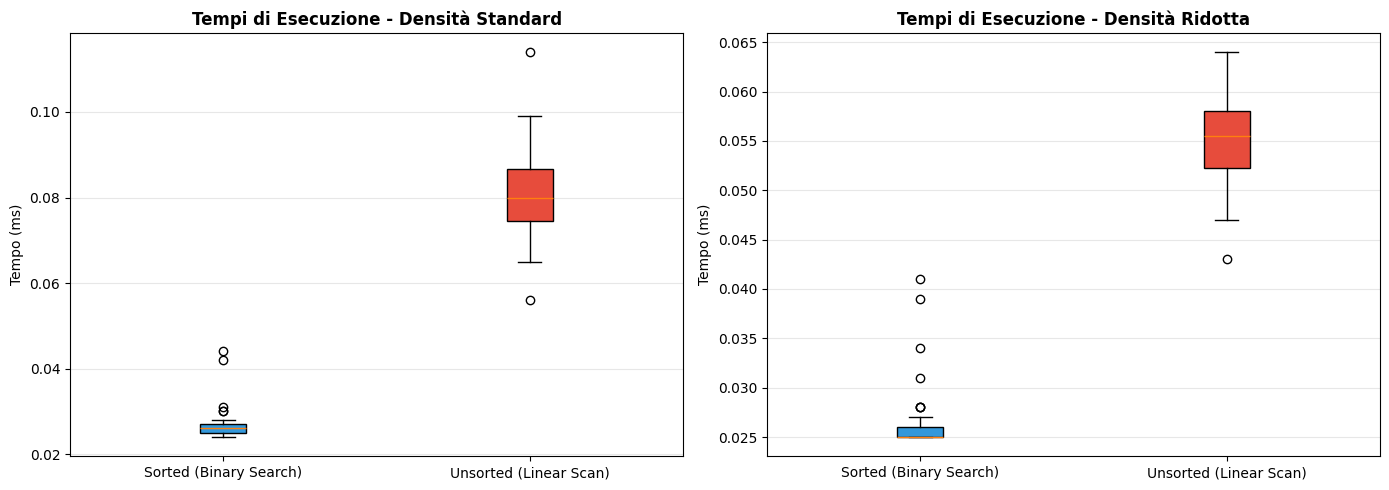


--- Statistiche Tempi di Esecuzione ---
Algoritmo                 | Densità Standard (ms)  | Densità Ridotta (ms)  
---------------------------------------------------------------------------
Sorted (media ± std)      | 0.0269 ± 0.0036 | 0.0264 ± 0.0032
Unsorted (media ± std)    | 0.0810 ± 0.0096 | 0.0554 ± 0.0049


In [450]:
# ---------------------------------------------------------
# 5.1 BOXPLOT TEMPI DI ESECUZIONE
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Densità Standard
data_exec_std = [tempi_sorted_std, tempi_unsorted_std]
bp1 = axes[0].boxplot(data_exec_std, tick_labels=['Sorted (Binary Search)', 'Unsorted (Linear Scan)'], patch_artist=True)
bp1['boxes'][0].set_facecolor('#3498db')
bp1['boxes'][1].set_facecolor('#e74c3c')
axes[0].set_title('Tempi di Esecuzione - Densità Standard', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tempo (ms)')
axes[0].grid(axis='y', alpha=0.3)

# Grafico 2: Densità Ridotta
data_exec_red = [tempi_sorted_red, tempi_unsorted_red]
bp2 = axes[1].boxplot(data_exec_red, tick_labels=['Sorted (Binary Search)', 'Unsorted (Linear Scan)'], patch_artist=True)
bp2['boxes'][0].set_facecolor('#3498db')
bp2['boxes'][1].set_facecolor('#e74c3c')
axes[1].set_title('Tempi di Esecuzione - Densità Ridotta', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Tempo (ms)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/boxplot_tempi_esecuzione.png', dpi=150, bbox_inches='tight')
plt.show()

# Stampa statistiche
print("\n--- Statistiche Tempi di Esecuzione ---")
print(f"{'Algoritmo':<25} | {'Densità Standard (ms)':<22} | {'Densità Ridotta (ms)':<22}")
print("-" * 75)
print(f"{'Sorted (media ± std)':<25} | {np.mean(tempi_sorted_std):.4f} ± {np.std(tempi_sorted_std):.4f} | {np.mean(tempi_sorted_red):.4f} ± {np.std(tempi_sorted_red):.4f}")
print(f"{'Unsorted (media ± std)':<25} | {np.mean(tempi_unsorted_std):.4f} ± {np.std(tempi_unsorted_std):.4f} | {np.mean(tempi_unsorted_red):.4f} ± {np.std(tempi_unsorted_red):.4f}")

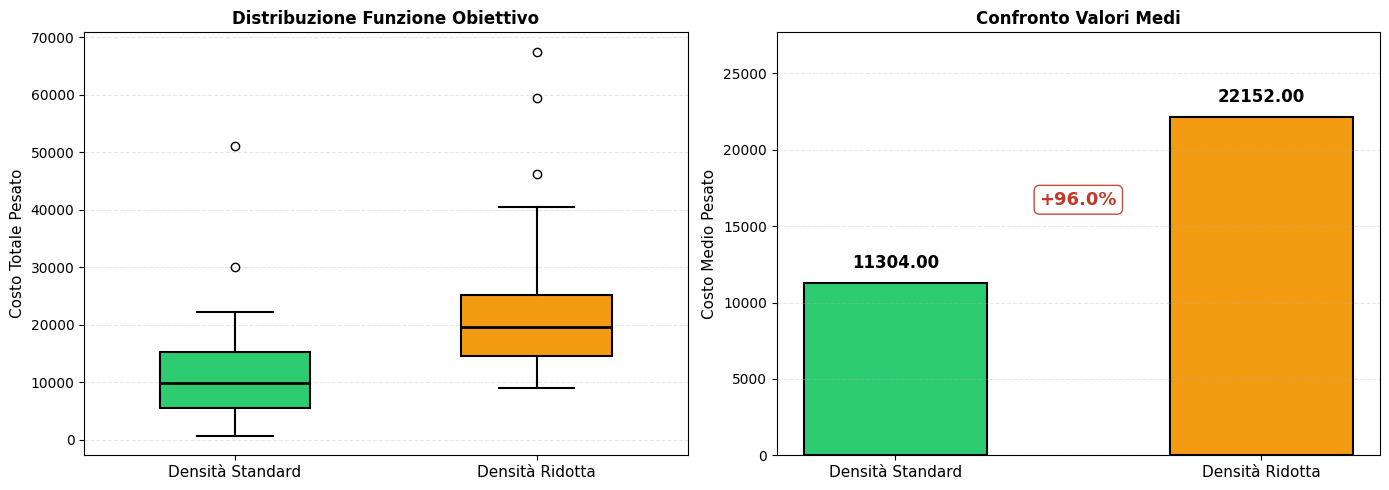


--- Statistiche Funzione Obiettivo ---
Configurazione       | Media        | Std Dev      | Min          | Max         
------------------------------------------------------------------------
Densità Standard     | 11304.00     | 8267.70      | 600.00       | 51000.00    
Densità Ridotta      | 22152.00     | 11897.01     | 9000.00      | 67500.00    

📈 Incremento medio costo con densità ridotta: +96.0%


In [451]:
# ---------------------------------------------------------
# 5.2 BOXPLOT E ISTOGRAMMA FUNZIONE OBIETTIVO
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calcolo delle medie
mean_std = np.mean(obj_std)
mean_red = np.mean(obj_red)

# --- GRAFICO 1: BOXPLOT ---
ax1 = axes[0]
data_obj = [obj_std, obj_red]
positions = [1, 2]

bp = ax1.boxplot(data_obj, positions=positions, widths=0.5, patch_artist=True,
                 boxprops=dict(linewidth=1.5),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5),
                 medianprops=dict(linewidth=2, color='black'))
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#f39c12')

ax1.set_xticks(positions)
ax1.set_xticklabels(['Densità Standard', 'Densità Ridotta'], fontsize=11)
ax1.set_title('Distribuzione Funzione Obiettivo', fontsize=12, fontweight='bold')
ax1.set_ylabel('Costo Totale Pesato', fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# --- GRAFICO 2: ISTOGRAMMA MEDIE ---
ax2 = axes[1]
x_labels = ['Densità Standard', 'Densità Ridotta']
x_pos = np.arange(len(x_labels))
medie = [mean_std, mean_red]
colors = ['#2ecc71', '#f39c12']

bars = ax2.bar(x_pos, medie, color=colors, edgecolor='black', width=0.5, linewidth=1.5)

# Etichette sui bars
for bar, val in zip(bars, medie):
    height = bar.get_height()
    ax2.annotate(f'{val:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 8),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Calcolo incremento percentuale
incremento = ((mean_red - mean_std) / mean_std) * 100

# Annotazione percentuale tra le barre
ax2.annotate(f'+{incremento:.1f}%', 
             xy=(0.5, (mean_std + mean_red) / 2), 
             fontsize=13, fontweight='bold', color='#c0392b',
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#c0392b', alpha=0.9))

ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels, fontsize=11)
ax2.set_title('Confronto Valori Medi', fontsize=12, fontweight='bold')
ax2.set_ylabel('Costo Medio Pesato', fontsize=11)
ax2.set_ylim(0, max(medie) * 1.25)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('results/figures/boxplot_istogramma_funzione_obiettivo.png', dpi=150, bbox_inches='tight')
plt.show()

# Stampa statistiche
print("\n--- Statistiche Funzione Obiettivo ---")
print(f"{'Configurazione':<20} | {'Media':<12} | {'Std Dev':<12} | {'Min':<12} | {'Max':<12}")
print("-" * 72)
print(f"{'Densità Standard':<20} | {mean_std:<12.2f} | {np.std(obj_std):<12.2f} | {np.min(obj_std):<12.2f} | {np.max(obj_std):<12.2f}")
print(f"{'Densità Ridotta':<20} | {mean_red:<12.2f} | {np.std(obj_red):<12.2f} | {np.min(obj_red):<12.2f} | {np.max(obj_red):<12.2f}")
print(f"\n📈 Incremento medio costo con densità ridotta: +{incremento:.1f}%")

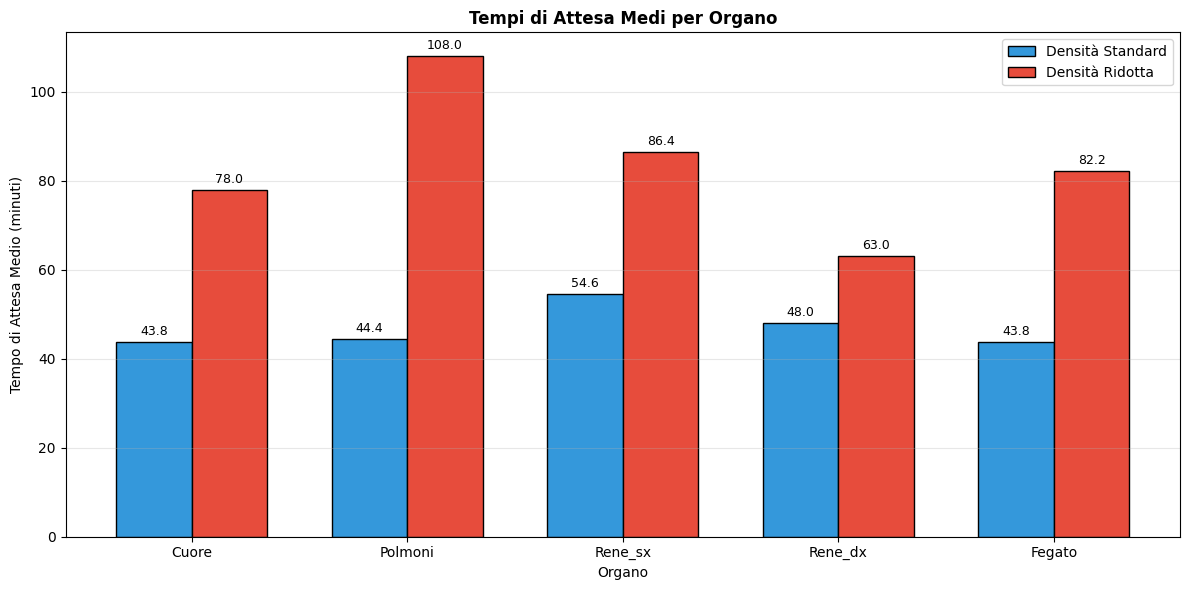


--- Tempi di Attesa Medi per Organo (minuti) ---
Organo       | Peso   | Densità Standard   | Densità Ridotta   
------------------------------------------------------------
Cuore        | 100    | 43.80              | 78.00             
Polmoni      | 90     | 44.40              | 108.00            
Rene_sx      | 20     | 54.60              | 86.40             
Rene_dx      | 20     | 48.00              | 63.00             
Fegato       | 20     | 43.80              | 82.20             


In [452]:
# ---------------------------------------------------------
# 5.3 ISTOGRAMMA TEMPI DI ATTESA MEDI PER ORGANO
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Calcolo medie per organo
medie_std = [np.mean(attese_std[o]) if attese_std[o] else 0 for o in ORGANI]
medie_red = [np.mean(attese_red[o]) if attese_red[o] else 0 for o in ORGANI]

x = np.arange(len(ORGANI))
width = 0.35

bars1 = ax.bar(x - width/2, medie_std, width, label='Densità Standard', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, medie_red, width, label='Densità Ridotta', color='#e74c3c', edgecolor='black')

# Etichette sui bars
def autolabel(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(bars1, ax)
autolabel(bars2, ax)

ax.set_xlabel('Organo')
ax.set_ylabel('Tempo di Attesa Medio (minuti)')
ax.set_title('Tempi di Attesa Medi per Organo', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ORGANI)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/istogramma_attese_medie.png', dpi=150, bbox_inches='tight')
plt.show()

# Tabella riassuntiva
print("\n--- Tempi di Attesa Medi per Organo (minuti) ---")
print(f"{'Organo':<12} | {'Peso':<6} | {'Densità Standard':<18} | {'Densità Ridotta':<18}")
print("-" * 60)
for i, organo in enumerate(ORGANI):
    peso = PESO_ORGANI[organo]
    print(f"{organo:<12} | {peso:<6.0f} | {medie_std[i]:<18.2f} | {medie_red[i]:<18.2f}")

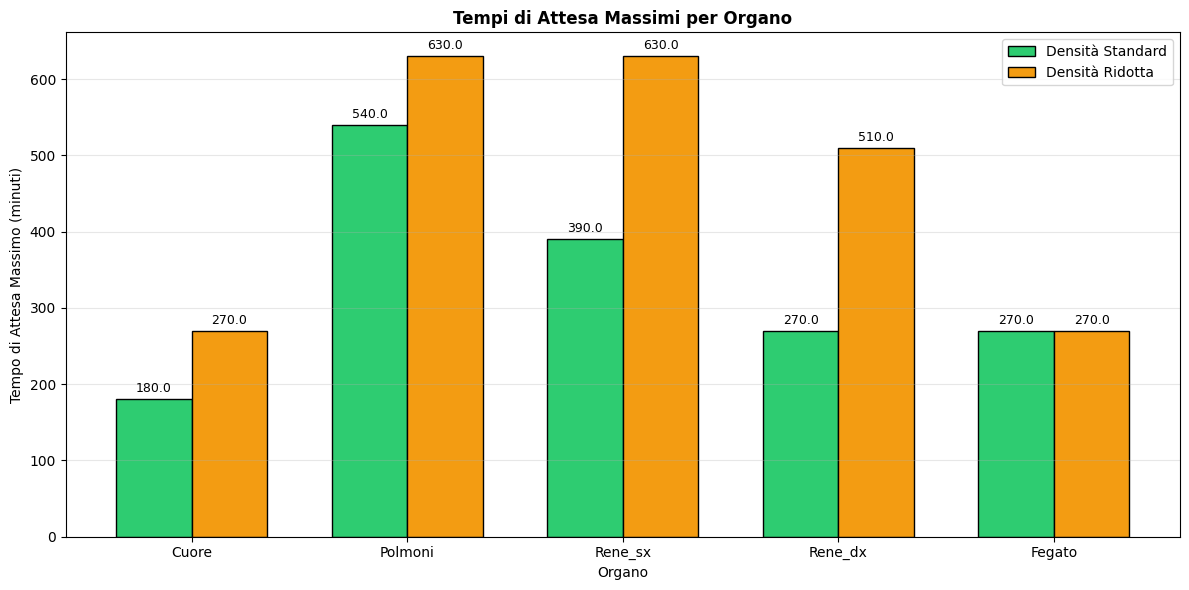


--- Tempi di Attesa Massimi per Organo (minuti) ---
Organo       | Peso   | Densità Standard   | Densità Ridotta   
------------------------------------------------------------
Cuore        | 100    | 180.00             | 270.00            
Polmoni      | 90     | 540.00             | 630.00            
Rene_sx      | 20     | 390.00             | 630.00            
Rene_dx      | 20     | 270.00             | 510.00            
Fegato       | 20     | 270.00             | 270.00            


In [453]:
# ---------------------------------------------------------
# 5.4 ISTOGRAMMA TEMPI DI ATTESA MASSIMI PER ORGANO
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Calcolo massimi per organo
massimi_std = [np.max(attese_std[o]) if attese_std[o] else 0 for o in ORGANI]
massimi_red = [np.max(attese_red[o]) if attese_red[o] else 0 for o in ORGANI]

x = np.arange(len(ORGANI))
width = 0.35

bars1 = ax.bar(x - width/2, massimi_std, width, label='Densità Standard', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, massimi_red, width, label='Densità Ridotta', color='#f39c12', edgecolor='black')

# Etichette sui bars
autolabel(bars1, ax)
autolabel(bars2, ax)

ax.set_xlabel('Organo')
ax.set_ylabel('Tempo di Attesa Massimo (minuti)')
ax.set_title('Tempi di Attesa Massimi per Organo', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ORGANI)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/istogramma_attese_massime.png', dpi=150, bbox_inches='tight')
plt.show()

# Tabella riassuntiva
print("\n--- Tempi di Attesa Massimi per Organo (minuti) ---")
print(f"{'Organo':<12} | {'Peso':<6} | {'Densità Standard':<18} | {'Densità Ridotta':<18}")
print("-" * 60)
for i, organo in enumerate(ORGANI):
    peso = PESO_ORGANI[organo]
    print(f"{organo:<12} | {peso:<6.0f} | {massimi_std[i]:<18.2f} | {massimi_red[i]:<18.2f}")

## 6. Conclusioni

L'analisi condotta ha permesso di valutare l'efficacia dell'approccio di ottimizzazione robusta per la pianificazione degli orari di prelievo organi. Di seguito si riportano le principali evidenze emerse dalla sperimentazione:

### 1. Efficienza Computazionale
Il confronto tra le due varianti dell'algoritmo ha confermato la netta superiorità dell'approccio **Sorted (Ricerca Binaria)** rispetto a quello **Unsorted (Scansione Lineare)**.
*   L'algoritmo `sorted` ha mostrato tempi di esecuzione drasticamente inferiori, nell'ordine dei millisecondi, rendendolo idoneo per applicazioni real-time anche con dataset di grandi dimensioni.
*   L'algoritmo `unsorted`, pur corretto, presenta tempi di calcolo che crescono linearmente con il numero di partenze, risultando meno scalabile.

### 2. Impatto della Densità dei Trasporti
L'analisi di sensitività ha evidenziato come la disponibilità di mezzi di trasporto influenzi significativamente la qualità della soluzione:
*   La riduzione della densità degli orari di partenza (rimozione del 50% delle opzioni) ha comportato un **aumento del costo medio della funzione obiettivo** (ritardo totale pesato).
*   Questo incremento quantifica il "prezzo" della flessibilità logistica: avere meno opzioni di trasporto costringe ad accettare tempi di attesa più lunghi per garantire la robustezza rispetto alla durata dell'intervento.

### 3. Rispetto delle Priorità Cliniche
I risultati confermano che il modello rispetta rigorosamente la gerarchia clinica imposta dai pesi:
*   Gli organi "salvavita" con pesi maggiori (**Cuore** e **Polmoni**) presentano tempi di attesa medi e massimi sistematicamente inferiori rispetto agli altri organi.
*   Gli organi con priorità minore (Reni e Fegato) assorbono la maggior parte dei ritardi necessari per accomodare l'incertezza, fungendo da "buffer" per proteggere la qualità degli organi più critici.

### 4. Limitazioni del Modello
È fondamentale sottolineare che il modello sviluppato rappresenta una **semplificazione della realtà operativa**.
*   **Dati Sintetici:** Gli orari di partenza e le durate sono stati generati artificialmente e potrebbero non riflettere la complessità delle reali disponibilità logistiche (es. traffico, meteo, disponibilità piloti).
*   **Vincoli Operativi:** Non sono stati considerati vincoli reali come i tempi di ischemia fredda massimi tollerabili per ciascun organo, la disponibilità delle sale operatorie o il coordinamento con le équipe di prelievo.
*   **Incertezza:** L'incertezza è stata modellata solo sulla durata dell'intervento, mentre nella realtà esistono molteplici fonti di aleatorietà.

Pertanto, i risultati ottenuti, sebbene validi dal punto di vista algoritmico e metodologico, devono essere interpretati come una dimostrazione concettuale (Proof of Concept) e non come una simulazione fedele di uno scenario reale di trapianto.

### Sintesi
In conclusione, il sistema proposto si dimostra uno strumento efficace per il supporto alle decisioni in ambito trapiantologico. L'approccio **Minimax** garantisce che, anche nel caso peggiore di durata dell'intervento, i ritardi per gli organi critici siano minimizzati. L'utilizzo di algoritmi di ricerca efficienti (`sorted`) permette inoltre di esplorare rapidamente numerosi scenari, rendendo il tool utilizzabile in contesti operativi dinamici.